In [ ]:
"""
Phần này dùng để đánh giá khi có folder ảnh và chưa tạo ra inter_pairs và intra_pairs.
Nếu bạn đã chạy lệnh "python preprocess_ailab_img.py" không cần chạy phần này, chuyển xuống phần tiếp theo.
"""
# from extract_face import img
from config import get_config
from glob import glob
from utils import get_pred, get_pairs_intra_label, get_pairs_inter_label, findDistance_cos, findDistance, calc_diff_and_similar
from Learner import face_learner
# print(findDistance(np.array([2, 2]), np.array([1, 1])))

conf = get_config(False)
list_label_folder = glob(f"{conf.infer_dataset}/*")
list_label_folder = [folder for folder in list_label_folder if len(glob(f"{folder}/*")) != 0]

all_intra_pairs, all_inter_pairs = [], []

for path in list_label_folder[:10]:
    intra_pairs = get_pairs_intra_label(path)
    all_intra_pairs += intra_pairs
#     print(get_pairs_inter_label(path, list_label_folder, intra_pairs))
    all_inter_pairs += get_pairs_inter_label(path, list_label_folder, intra_pairs)

learner = face_learner(conf, True)
# learner.threshold = 1.54
if conf.device.type == 'cpu':
    learner.load_state(conf, 'cpu_final.pth', True, True)
else:
    learner.load_state(conf, 'final.pth', True, True)
learner.model.eval()
print('learner loaded')


diff1, similar1 = calc_diff_and_similar(all_inter_pairs, all_intra_pairs, conf, learner, findDistance, tta=False)
diff2, similar2 = calc_diff_and_similar(all_inter_pairs, all_intra_pairs, conf, learner, findDistance_cos, tta=False)


In [3]:
# from extract_face import img
from config import get_config
from glob import glob
import torch
import pickle
from utils import get_pred, get_pairs_intra_label, get_pairs_inter_label, findDistance_cos, findDistance, calc_diff_and_similar
from Learner import face_learner
# print(findDistance(np.array([2, 2]), np.array([1, 1])))

conf = get_config(False)
# conf.device = torch.device("cuda:1")

all_inter_pairs_pkl = "/media/2tb/data/detected_img/inter_pair_10k.pkl"

all_intra_pairs_pkl = "/media/2tb/data/detected_img/intra_pair_IPCGANs_10k.pkl"

learner = face_learner(conf, True)
# learner.threshold = 1.54

if conf.device.type == 'cpu':
    learner.load_state('cpu_final.pth', True, True)
else:
    learner.load_state('ir_se50.pth', True, True)
learner.model.eval()
print('learner loaded')

with open(all_inter_pairs_pkl, 'rb') as file_images:
    all_inter_pairs = pickle.load(file_images)

with open(all_intra_pairs_pkl, 'rb') as file_images:
    all_intra_pairs = pickle.load(file_images)

diff1, similar1 = calc_diff_and_similar(all_inter_pairs, all_intra_pairs, conf, learner, findDistance, tta=False)
diff2, similar2 = calc_diff_and_similar(all_inter_pairs, all_intra_pairs, conf, learner, findDistance_cos, tta=False)


{'raw_data': PosixPath('/media/ailab/DATA/facescrub2'), 'dataset_name': 'facescrub', 'dataset_ratio_val': 0.2, 'processed_data': PosixPath('pre_processed'), 'train_path': PosixPath('pre_processed/facescrub/train'), 'val_path': PosixPath('pre_processed/facescrub/val'), 'pickle_train_images': PosixPath('pre_processed/facescrub/train/faces_ailab_112x112.pickle'), 'pickle_val_inter': PosixPath('pre_processed/facescrub/val/faces_ailab_112x112_inter.pickle'), 'pickle_val_intra': PosixPath('pre_processed/facescrub/val/faces_ailab_112x112_intra.pickle'), 'pickle_class_labels': PosixPath('pre_processed/facescrub/faces_ailab_labels.pickle'), 'data_path': PosixPath('data'), 'work_path': PosixPath('work_space'), 'model_path': PosixPath('work_space/models'), 'log_path': PosixPath('work_space/log'), 'save_path': PosixPath('work_space/save'), 'input_size': [112, 112], 'embedding_size': 512, 'use_mobilfacenet': False, 'net_depth': 50, 'drop_ratio': 0.6, 'net_mode': 'ir_se', 'device': device(type='cuda

<AxesSubplot:>

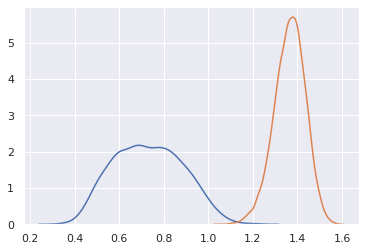

In [4]:
%matplotlib inline
import seaborn as sns

sns.set(color_codes=True)
sns.distplot(similar1, hist=False)
sns.distplot(diff1, hist=False)

<AxesSubplot:>

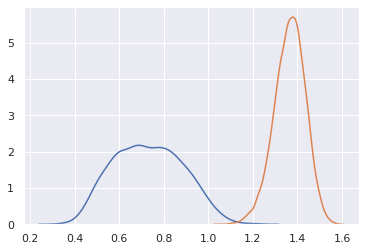

In [5]:
%matplotlib inline
import seaborn as sns

sns.set(color_codes=True)
sns.distplot(similar1, hist=False)
sns.distplot(diff1, hist=False)

<AxesSubplot:>

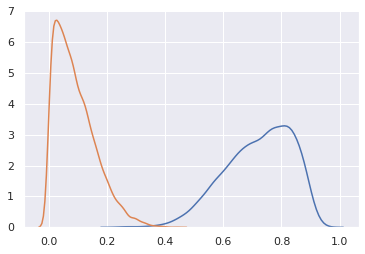

In [6]:
sns.set(color_codes=True)
sns.distplot(similar2, hist=False)
sns.distplot(diff2, hist=False)

In [7]:
range1 = [1, 1.2, 1.4]
range2 = [0.4, 0.7, 1]


step = 0.1
import numpy as np
y_true = np.concatenate((np.zeros(len(diff1)) , np.ones(len(similar1))), axis=0) 


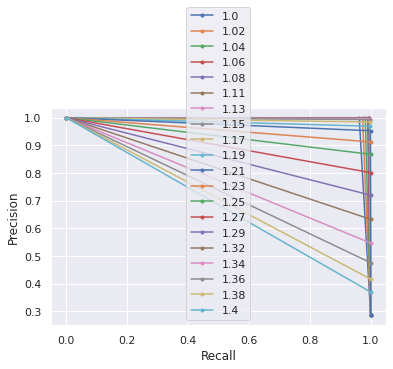

In [8]:
from sklearn.metrics import precision_recall_curve, f1_score, auc, precision_recall_curve
from matplotlib import pyplot

for threshold in np.linspace(1,1.4,20): 
    y_pred = get_pred(diff1, similar1, threshold)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pyplot.plot(recall, precision, marker='.', label=round(threshold, 2))

# threshold = 1.17
# y_pred = get_pred(diff1, similar1, threshold)
# precision, recall, _ = precision_recall_curve(y_true, y_pred)
# pyplot.plot(recall, precision, marker='.', label=round(threshold, 2))
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()

In [9]:
y_pred = get_pred(diff1, similar1, 1.16)
TP = len([ytrue for ytrue, ypred in zip(y_true, y_pred) if ytrue == ypred == True])
TN = len([ytrue for ytrue, ypred in zip(y_true, y_pred) if ytrue == ypred == False])
FP = len([ytrue for ytrue, ypred in zip(y_true, y_pred) if ytrue != ypred and ypred == False])
FN = len([ytrue for ytrue, ypred in zip(y_true, y_pred) if ytrue != ypred and ypred == True])
precision = TP/(TP+FN)
recall = TP/(TP+FP)
print(TP, TN, FP, FN, len(y_pred), precision, recall)

3993 9955 7 45 14000 0.9888558692421991 0.99825


Best Threshold=1.000000, G-Mean=0.997
Best tpr=0.998250, fpr=0.004500


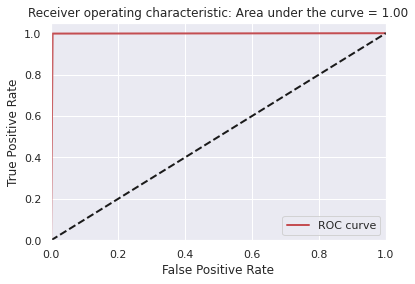

In [10]:
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                             average_precision_score, classification_report,
                             confusion_matrix)
def plot_roc(true_label, prediction):
    fpr, tpr, threshs = roc_curve(true_label, prediction)
    auc_res = auc(fpr, tpr)

    # compute optimal threshold
    optimal_threshold_roc(tpr, fpr, threshs)

    # plot
    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.title('Receiver operating characteristic: Area under the curve '
              '= {0:0.2f}'.format(auc_res))
    plt.legend(loc='lower right')
    plt.show()

def optimal_threshold_roc(tpr, fpr, threshs):
    g_means = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(g_means)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshs[ix], g_means[ix]))
    print('Best tpr=%f, fpr=%f' % (tpr[ix], fpr[ix]))

    return threshs[ix]
import matplotlib.pyplot as plt
plot_roc(y_true, y_pred)

Best Threshold=-0.033392, G-Mean=0.807
Best tpr=0.860000, fpr=0.243030


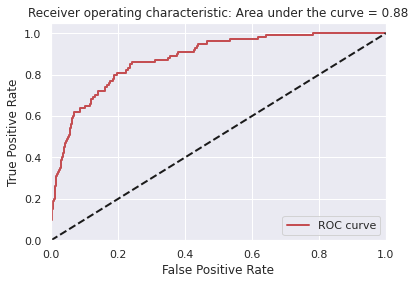

In [11]:
mean1 = [0, -0.25] # Negative
cov1 = [[0.1, 0.001],[0.001, 0.1]]
v1 = np.random.multivariate_normal(mean1, cov1, 9900)

mean2 = [0, 0.25] # Positive
cov2 = [[0.1, 0.001],[0.001, 0.1]]
v2 = np.random.multivariate_normal(mean2, cov2, 100)

true_label = np.concatenate((np.zeros(len(v1)), np.ones(len(v2))), axis=None)
predictions = np.concatenate((v1[:, 1], v2[:, 1]), axis=None)


plot_roc(true_label, predictions)